In [1]:
# import libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import chi2_contingency, ttest_ind
from sklearn.feature_selection import mutual_info_classif, f_classif
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import precision_score, recall_score, f1_score

from sklearn.utils.class_weight import compute_class_weight

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, accuracy_score

### Which campaign performed the best & why?

Key Steps:
1. Loading and Exploring Data
2. Computing Key Metrics (Visit Rate, Conversion Rate, Average Spend)
3. Statistical Testing (Chi-square and T-tests) for Significance
4. Visualizing Results


In [2]:
# Load dataset (update file path accordingly)
df = pd.read_csv("digital_marketing_dataset.csv")

# Basic dataset overview
print(df.head())
print(df.info())

   months_since_last_purchase  history_spend  history_footwear  \
0                          10         142.44                 1   
1                           6         329.08                 1   
2                           7         180.65                 0   
3                           9         675.83                 1   
4                           2          45.34                 1   

   history_apparel address_category  acquired_in_last_year channel  \
0                0        Surburban                      0   Phone   
1                1            Rural                      1     Web   
2                1        Surburban                      1     Web   
3                0            Rural                      1     Web   
4                0            Urban                      0     Web   

  campaign_segment  visit  conversion  spend  
0  Footwear E-Mail      0           0    0.0  
1        No E-Mail      0           0    0.0  
2  Footwear E-Mail      0           0    

In [3]:
# Campaign Performance Analysis
metrics = df.groupby("campaign_segment").agg(
    user_count=("campaign_segment", "count"),
    visit_rate=("visit", "mean"),
    conversion_count=("conversion", "sum"),
    conversion_rate=("conversion", "mean"),
    avg_spend=("spend", "mean")
).reset_index()

print(metrics)

  campaign_segment  user_count  visit_rate  conversion_count  conversion_rate  \
0   Apparel E-Mail       21307    0.182757               267         0.012531   
1  Footwear E-Mail       21387    0.151400               189         0.008837   
2        No E-Mail       21306    0.106167               122         0.005726   

   avg_spend  
0   1.422617  
1   1.077202  
2   0.652789  


In [4]:
# Statistical Testing
footwear = df[df["campaign_segment"] == "Footwear E-Mail"]
apparel = df[df["campaign_segment"] == "Apparel E-Mail"]
no_email =df[df["campaign_segment"] == "No E-Mail"]

# Chi-Square Test for Visit & Conversion Rates
visit_contingency = [[footwear["visit"].sum(), footwear.shape[0] - footwear["visit"].sum()],
                     [apparel["visit"].sum(), apparel.shape[0] - apparel["visit"].sum()],
                     [no_email["visit"].sum(), no_email.shape[0] - no_email["visit"].sum()]]
conversion_contingency = [[footwear["conversion"].sum(), footwear.shape[0] - footwear["conversion"].sum()],
                          [apparel["conversion"].sum(), apparel.shape[0] - apparel["conversion"].sum()],
                          [no_email["conversion"].sum(), no_email.shape[0] - no_email["conversion"].sum()]]

chi2_visits, p_visits, _, _ = chi2_contingency(visit_contingency)
chi2_conversion, p_conversion, _, _ = chi2_contingency(conversion_contingency)

In [5]:
print(f"Chi-square test for visit rates: p-value = {p_visits:.4f}")
print(f"Chi-square test for conversion rates: p-value = {p_conversion:.4f}")

Chi-square test for visit rates: p-value = 0.0000
Chi-square test for conversion rates: p-value = 0.0000


In [6]:
def pair_wise_chi(group1, group2, label):
    contingency = [[group1["conversion"].sum(), group1.shape[0]-group1["conversion"].sum()],
                   [group2["conversion"].sum(), group2.shape[0]-group2["conversion"].sum()]]
    chi2_conversion, p_conversion, _, _ =chi2_contingency(contingency)
    print(f'Pair-wise Chi2 test for conversion rate for {label} : p-value = {p_conversion:.4f}')

pair_wise_chi(footwear, no_email, 'Footwear vs No-Email')
pair_wise_chi(apparel, no_email, 'Apparel vs No-Email')
pair_wise_chi(apparel, footwear, 'Apparel vs Footwear')

Pair-wise Chi2 test for conversion rate for Footwear vs No-Email : p-value = 0.0002
Pair-wise Chi2 test for conversion rate for Apparel vs No-Email : p-value = 0.0000
Pair-wise Chi2 test for conversion rate for Apparel vs Footwear : p-value = 0.0002


In [7]:
# T-test for Spend
t_stat, p_spend = ttest_ind(footwear["spend"], apparel["spend"], nan_policy='omit')
print(f"T-test for spend: p-value = {p_spend:.4f}")


T-test for spend: p-value = 0.0304



* Since p < 0.05, we conclude that the average spending differs significantly between the two campaign groups
* Customer group targeted with email for Apparel is spending noticeably more post-campaign


C:\Users\dmata\AppData\Local\Temp\ipykernel_11576\4213973557.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=metrics, x="campaign_segment", y="visit_rate", ax=axes[0], palette="viridis")
C:\Users\dmata\AppData\Local\Temp\ipykernel_11576\4213973557.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=metrics, x="campaign_segment", y="conversion_rate", ax=axes[1], palette="coolwarm")
C:\Users\dmata\AppData\Local\Temp\ipykernel_11576\4213973557.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=metrics, x="campaign_segment",

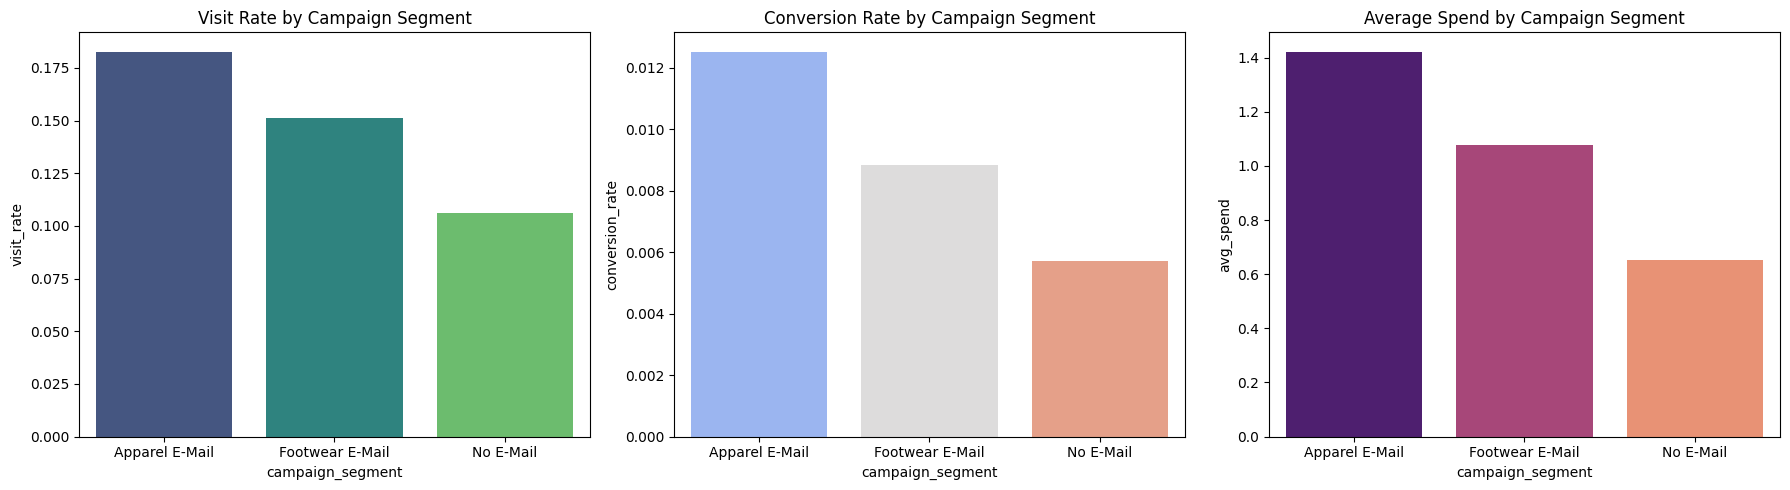

In [8]:
# Visualization
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

sns.barplot(data=metrics, x="campaign_segment", y="visit_rate", ax=axes[0], palette="viridis")
axes[0].set_title("Visit Rate by Campaign Segment")

sns.barplot(data=metrics, x="campaign_segment", y="conversion_rate", ax=axes[1], palette="coolwarm")
axes[1].set_title("Conversion Rate by Campaign Segment")

sns.barplot(data=metrics, x="campaign_segment", y="avg_spend", ax=axes[2], palette="magma")
axes[2].set_title("Average Spend by Campaign Segment")

plt.tight_layout()
plt.show()


* Apparel Email campaign drove significantly more website visits than the other
* It led to more actual purchases than the Footwear campaign

Let's find out why this is happening?

We will break down the performance based on:
* Customer type (New vs Existing)
* Address Category (Assess the campaign performance in Rural, Suburban & Urban buyers)
* Purchase History (Previous Footwear Buyers vs. Previous Apparel Buyers (using history_footwear, history_apparel) - Are customers buying what they were targeted for, or is cross-category marketing working?
* Segment customers into high, medium, and low spenders to see which group responded better

In [9]:
def segment_analysis(segment_col):
    segment_metrics = df.groupby(['campaign_segment', segment_col]).agg(
                            visit_rate = ('visit','mean'), 
                            conversion_rate = ('conversion','mean'), 
                            avg_spend = ('spend', 'mean')).reset_index()
    return segment_metrics

<Axes: xlabel='history_apparel', ylabel='conversion_rate'>

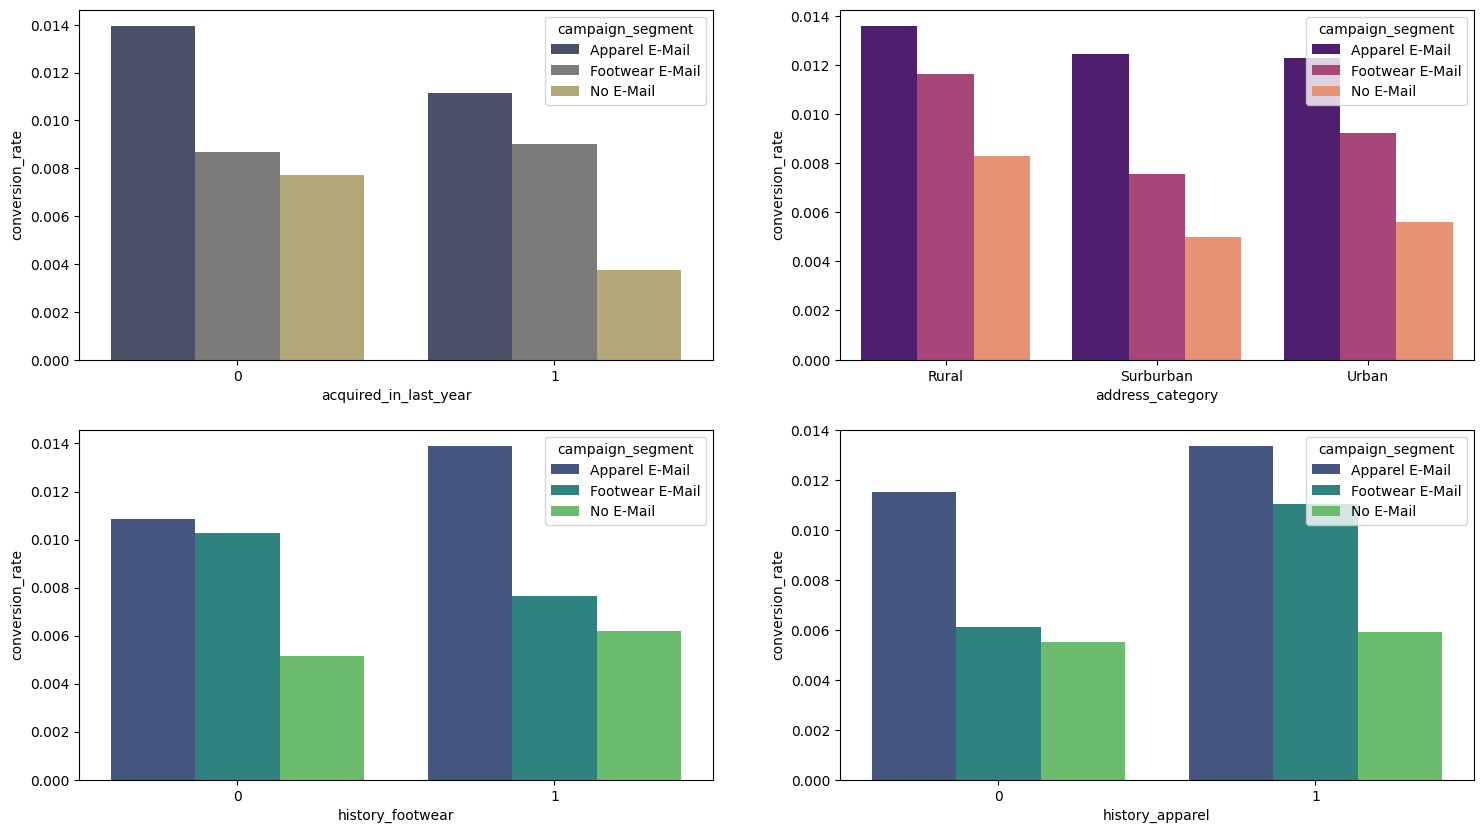

In [10]:
new_vs_existing_metrics = segment_analysis('acquired_in_last_year')
address_metrics = segment_analysis('address_category')
purchase_history_footwear = segment_analysis('history_footwear')
purchase_history_apparel = segment_analysis('history_apparel')

fig, axes = plt.subplots(2,2, figsize=(18,10))
sns.barplot(data = new_vs_existing_metrics, x = 'acquired_in_last_year', y='conversion_rate', 
            hue = 'campaign_segment', ax = axes[0,0], palette="cividis")
sns.barplot(data = address_metrics, x = 'address_category', y='conversion_rate', 
            hue = 'campaign_segment', ax = axes[0,1], palette="magma")
sns.barplot(data = purchase_history_footwear, x = 'history_footwear', y='conversion_rate', 
            hue = 'campaign_segment', ax = axes[1,0], palette="viridis")
sns.barplot(data = purchase_history_apparel, x = 'history_apparel', y='conversion_rate', 
            hue = 'campaign_segment', ax = axes[1,1], palette="viridis")

In [11]:
df['spend_category'] = pd.qcut(df['history_spend'], q= 3, labels=["Low", "Medium", "High"])

In [12]:
def best_campaign_by_segment(segment_col):
    segment_metrics = df.groupby(["campaign_segment", segment_col]).agg(
        conversion_rate=("conversion", "mean"),
        visit_rate=("visit", "mean"),
        avg_spend=("spend", "mean"),
        count=("spend", "count")
    ).reset_index()

    # Find which campaign performs better for each segment
    best_performing = segment_metrics.loc[segment_metrics.groupby(segment_col)["conversion_rate"].idxmax()]
    print(f"Best performing campaign for each {segment_col}:")
    print(best_performing)
    return best_performing

# Analyze campaign performance across key segments
best_by_location = best_campaign_by_segment("address_category")
best_by_purchase_history = best_campaign_by_segment("history_footwear")
best_by_spend = best_campaign_by_segment("spend_category")
best_by_acquisition = best_campaign_by_segment("acquired_in_last_year")


Best performing campaign for each address_category:
  campaign_segment address_category  conversion_rate  visit_rate  avg_spend  \
0   Apparel E-Mail            Rural         0.013568    0.226950   1.522636   
1   Apparel E-Mail        Surburban         0.012420    0.173350   1.473290   
2   Apparel E-Mail            Urban         0.012262    0.176457   1.328512   

   count  
0   3243  
1   9501  
2   8563  
Best performing campaign for each history_footwear:
  campaign_segment  history_footwear  conversion_rate  visit_rate  avg_spend  \
0   Apparel E-Mail                 0         0.010870    0.166388   1.106295   
1   Apparel E-Mail                 1         0.013885    0.196098   1.680438   

   count  
0   9568  
1  11739  


C:\Users\dmata\AppData\Local\Temp\ipykernel_11576\2866062154.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  segment_metrics = df.groupby(["campaign_segment", segment_col]).agg(
C:\Users\dmata\AppData\Local\Temp\ipykernel_11576\2866062154.py:10: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  best_performing = segment_metrics.loc[segment_metrics.groupby(segment_col)["conversion_rate"].idxmax()]


Best performing campaign for each spend_category:
  campaign_segment spend_category  conversion_rate  visit_rate  avg_spend  \
0   Apparel E-Mail            Low         0.009213    0.152289   1.064266   
1   Apparel E-Mail         Medium         0.010614    0.172233   1.220415   
2   Apparel E-Mail           High         0.017804    0.224106   1.987260   

   count  
0   7164  
1   7066  
2   7077  
Best performing campaign for each acquired_in_last_year:
  campaign_segment  acquired_in_last_year  conversion_rate  visit_rate  \
0   Apparel E-Mail                      0         0.013935    0.211562   
1   Apparel E-Mail                      1         0.011136    0.154127   

   avg_spend  count  
0   1.513317  10621  
1   1.332468  10686  


### Key Findings
* The Apparel E-Mail campaign consistently has a higher conversion rate compared to the Footwear E-Mail campaign, regardless of the segment 
* Customers who were acquired in the last year show a higher conversion rate when targeted with the Apparel E-Mail compared to the Footwear E-Mail

#### Data Preprocessing

In [13]:
from sklearn.preprocessing import LabelEncoder

# Define target variable
target = 'conversion'
# Remove columns that are results from the campaign
df.drop(columns=["visit", "spend"], inplace=True)
# Identify numerical and categorical features
numerical_features = ['months_since_last_purchase', 'history_spend']
categorical_features = ['history_footwear', 'history_apparel', 'address_category', 
                        'acquired_in_last_year','channel', 'campaign_segment']

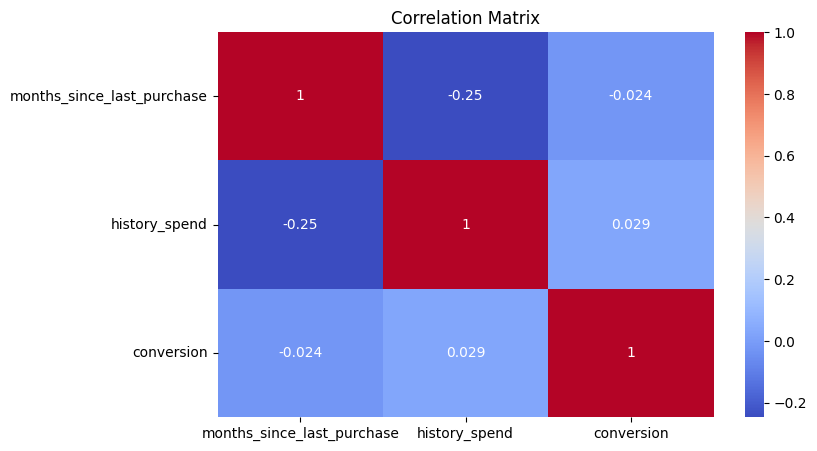

In [14]:
# Correlation Analysis (for numerical features)
plt.figure(figsize=(8, 5))
sns.heatmap(df[numerical_features + [target]].corr(), annot=True, cmap="coolwarm")
plt.title("Correlation Matrix")
plt.show()

In [15]:
df_encoded = df.copy()

In [16]:
# Mutual Information Scores (for all features to detect any kind of relationship)

for col in categorical_features:
    df_encoded[col] = LabelEncoder().fit_transform(df[col])

# Compute Mutual Information scores
features = numerical_features + categorical_features
mi_scores = mutual_info_classif(df_encoded[features], df_encoded[target])
mi_scores = pd.Series(mi_scores, index=features).sort_values(ascending=False)

print("\nMutual Information Scores:")
print(mi_scores)


Mutual Information Scores:
history_footwear              0.011031
history_apparel               0.010815
acquired_in_last_year         0.010587
channel                       0.006450
address_category              0.005648
campaign_segment              0.005523
months_since_last_purchase    0.001371
history_spend                 0.000446
dtype: float64


In [17]:
# Chi-Square Test for categorical features
chi2_results = {}
for col in categorical_features:
    contingency_table = pd.crosstab(df[col], df[target])
    chi2_stat, p, dof, expected = chi2_contingency(contingency_table)
    chi2_results[col] = p  # p-value tells us whether feature is independent of target

# Convert to DataFrame
chi2_results_df = pd.DataFrame.from_dict(chi2_results, orient='index', columns=['p-value']).sort_values(by='p-value')

print("\nChi-Square Test Results (p-values):")
print(chi2_results_df)


Chi-Square Test Results (p-values):
                            p-value
campaign_segment       1.002003e-12
channel                2.417251e-04
history_apparel        1.516896e-03
acquired_in_last_year  4.733327e-03
address_category       3.564280e-02
history_footwear       5.562825e-01


In [18]:
# ANOVA (F-Test) for Numerical Features
f_values, p_values = f_classif(df[numerical_features], df[target])
anova_results = pd.Series(p_values, index=numerical_features).sort_values()

print("\nANOVA Test Results (p-values):")
print(anova_results)

# Keep features with p-value < 0.05
important_features = list(anova_results[anova_results < 0.05].index) + list(chi2_results_df[chi2_results_df['p-value'] < 0.05].index)
print(f"\nStatistically significant features: {important_features}")


ANOVA Test Results (p-values):
history_spend                 1.004310e-13
months_since_last_purchase    6.547048e-10
dtype: float64

Statistically significant features: ['history_spend', 'months_since_last_purchase', 'campaign_segment', 'channel', 'history_apparel', 'acquired_in_last_year', 'address_category']


#### Preparing data for modeling

In [19]:
# Split data into Footwear & Apparel subsets
footwear_df = df_encoded[df_encoded["campaign_segment"] == 1]
apparel_df = df_encoded[df_encoded["campaign_segment"] == 0]


In [20]:

# Train-test split for both models
X_footwear_train, X_footwear_test, y_footwear_train, y_footwear_test = train_test_split(
    footwear_df[features], footwear_df[target], test_size=0.2, random_state=42)

X_apparel_train, X_apparel_test, y_apparel_train, y_apparel_test = train_test_split(
    apparel_df[features], apparel_df[target], test_size=0.2, random_state=42)


In [21]:
# Standardize numerical features
scaler = StandardScaler()
X_footwear_train[numerical_features] = scaler.fit_transform(X_footwear_train[numerical_features])
X_footwear_test[numerical_features] = scaler.transform(X_footwear_test[numerical_features])
X_apparel_train[numerical_features] = scaler.fit_transform(X_apparel_train[numerical_features])
X_apparel_test[numerical_features] = scaler.transform(X_apparel_test[numerical_features])


In [22]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=42)
X_footwear_train_resampled, y_footwear_train_resampled = smote.fit_resample(X_footwear_train, y_footwear_train)
X_apparel_train_resampled, y_apparel_train_resampled = smote.fit_resample(X_apparel_train, y_apparel_train)


In [23]:
from sklearn.utils.class_weight import compute_class_weight

# Compute Class Weights for Footwear
class_weights_footwear = compute_class_weight(class_weight="balanced", classes=np.unique(y_footwear_train), y=y_footwear_train)
class_weight_dict_footwear = {0: class_weights_footwear[0], 1: class_weights_footwear[1]}
print("Footwear Weights:", class_weight_dict_footwear)

# Compute Class Weights for Apparel
class_weights_apparel = compute_class_weight(class_weight="balanced", classes=np.unique(y_apparel_train), y=y_apparel_train)
class_weight_dict_apparel = {0: class_weights_apparel[0], 1: class_weights_apparel[1]}
print("Apparel Weights:", class_weight_dict_apparel)

Footwear Weights: {0: np.float64(0.5046009555830826), 1: np.float64(54.83653846153846)}
Apparel Weights: {0: np.float64(0.5062069375148491), 1: np.float64(40.77751196172249)}


In [24]:
# Train Logistic Regression models separately
footwear_model = LogisticRegression(max_iter=500, random_state=42)
apparel_model = LogisticRegression(max_iter=500, random_state=42)

footwear_model.fit(X_footwear_train_resampled, y_footwear_train_resampled)
apparel_model.fit(X_apparel_train_resampled, y_apparel_train_resampled)


LogisticRegression(max_iter=500, random_state=42)

In [25]:

# Predict probabilities
y_footwear_pred_prob = footwear_model.predict_proba(X_footwear_test)[:, 1]
y_apparel_pred_prob = apparel_model.predict_proba(X_apparel_test)[:, 1]

# Predict binary outcomes (default threshold = 0.5)
y_footwear_pred = (y_footwear_pred_prob >= 0.5).astype(int)
y_apparel_pred = (y_apparel_pred_prob >= 0.5).astype(int)

# Compute evaluation metrics for Footwear
footwear_metrics = {
    "ROC-AUC": roc_auc_score(y_footwear_test, y_footwear_pred_prob),
    "Precision": precision_score(y_footwear_test, y_footwear_pred, zero_division=1),
    "Recall": recall_score(y_footwear_test, y_footwear_pred, zero_division=1),
    "F1-Score": f1_score(y_footwear_test, y_footwear_pred, zero_division=1),
    "Accuracy": accuracy_score(y_footwear_test, y_footwear_pred)
}

# Compute evaluation metrics for Apparel
apparel_metrics = {
    "ROC-AUC": roc_auc_score(y_apparel_test, y_apparel_pred_prob),
    "Precision": precision_score(y_apparel_test, y_apparel_pred, zero_division=1),
    "Recall": recall_score(y_apparel_test, y_apparel_pred, zero_division=1),
    "F1-Score": f1_score(y_apparel_test, y_apparel_pred, zero_division=1),
    "Accuracy": accuracy_score(y_apparel_test, y_apparel_pred)
}

# Print model evaluation metrics
print("Footwear Model Performance:", footwear_metrics)
print("Apparel Model Performance:", apparel_metrics)

Footwear Model Performance: {'ROC-AUC': np.float64(0.6291929899703752), 'Precision': np.float64(0.011104256631708822), 'Recall': np.float64(0.5454545454545454), 'F1-Score': np.float64(0.02176541717049577), 'Accuracy': 0.6217858812529219}
Apparel Model Performance: {'ROC-AUC': np.float64(0.5913764395157322), 'Precision': np.float64(0.018794914317302378), 'Recall': np.float64(0.5862068965517241), 'F1-Score': np.float64(0.03642206748794858), 'Accuracy': 0.5778977006100422}


Since recall is high but precision is poor, the model identifies many actual converters but also misclassifies a large number of non-converters as converters.

In [26]:
# Apply models to the entire dataset
df_encoded["footwear_prob"] = footwear_model.predict_proba(df_encoded[features])[:, 1]
df_encoded["apparel_prob"] = apparel_model.predict_proba(df_encoded[features])[:, 1]


In [27]:
# Assign campaign based on the highest probability
df_encoded["recommended_campaign"] = np.where(
    df_encoded["footwear_prob"] > df_encoded["apparel_prob"], "Footwear E-Mail", "Apparel E-Mail"
)

In [28]:
# Check distribution of recommendations
print(df_encoded["recommended_campaign"].value_counts())

recommended_campaign
Apparel E-Mail    64000
Name: count, dtype: int64


In [29]:
# Add conversion probability scores to the original dataset
df_encoded["footwear_score"] = footwear_model.predict_proba(df_encoded[features])[:, 1]
df_encoded["apparel_score"] = apparel_model.predict_proba(df_encoded[features])[:, 1]

# Rank users based on the highest predicted conversion probability for each campaign
# select those with the highest likelihood of conversion
top_footwear_customers = df_encoded.nlargest(10000, "footwear_score")
top_apparel_customers = df_encoded.nlargest(10000, "apparel_score")


In [30]:
# Identify the bottom 10,000 customers with the lowest predicted conversion probabilities
bottom_footwear_customers = df_encoded.nsmallest(10000, "footwear_score")
bottom_apparel_customers = df_encoded.nsmallest(10000, "apparel_score")